# Tackling mnist dataset using ANN

**First approach**

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
data = keras.datasets.mnist.load_data()

In [3]:
print(f'{data[0][0].shape = }')
print(f'{data[0][1].shape = }')
print(f'{data[1][0].shape = }')
print(f'{data[1][1].shape = }')

data[0][0].shape = (60000, 28, 28)
data[0][1].shape = (60000,)
data[1][0].shape = (10000, 28, 28)
data[1][1].shape = (10000,)


In [4]:
X_train_full = data[0][0]
y_train_full = data[0][1]

X_test = data[1][0]
y_test = data[1][1]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

**Now let's try to build a good model that reaches high accuracy**

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(400, activation='relu', name='hidden1'),
    keras.layers.Dense(150, activation='relu', name='hidden2'),
    keras.layers.Dense(10, activation='softmax', name='output')
], name='The_net')

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We're going to find optimal learning rate using exponential schedule for one epoch and looking for loss jump.

In [7]:
K = keras.backend
losses = []
rates = []

class LrFindSchedule(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(LrFindSchedule, self).__init__()
        self.schedule = schedule
    
    def on_train_batch_begin(self, batch, logs=None):
        K.set_value(self.model.optimizer.lr, self.schedule(batch))
    
    def on_train_batch_end(self, batch, logs=None):
        losses.append(logs['loss'])
        rates.append(K.get_value(self.model.optimizer.lr))

def schedule(batch):
    return 1e-3 * np.exp(np.log(1e4)/500.0)**batch

lr_scheduler_cb = LrFindSchedule(schedule)

In [8]:
%%time

history = model.fit(X_train, y_train, batch_size=32, epochs=1, steps_per_epoch=500,
                    callbacks=[lr_scheduler_cb])

500/500 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.2051
Wall time: 2.24 s


(16.755290985107422, 109.21670532226562)

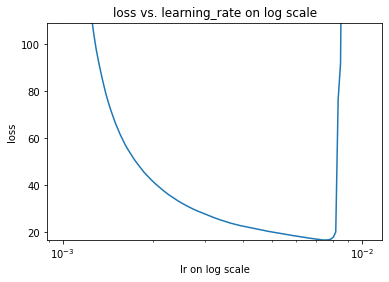

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(rates, losses)
plt.xscale('log')
plt.title('loss vs. learning_rate on log scale')
plt.xlabel('lr on log scale')
plt.ylabel('loss')
plt.ylim(min(losses), losses[0])

Looks like the loss goes up around `8e-3`, so we'll use `6e-3`.

Now, let's set learning rate to the `6e-3` and try to find optimal number of neurons in two layers.

In [10]:
def build_model(n_neurons_first_layer=400, n_neurons_second_layer=200, learning_rate=6e-3, activation_function='relu', input_shape=(28, 28)):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape, name='input'),
        keras.layers.Dense(n_neurons_first_layer, activation=activation_function, name='hidden1'),
        keras.layers.Dense(n_neurons_second_layer, activation=activation_function, name='hidden2'),
        keras.layers.Dense(10, activation='softmax', name='output')
    ], name='The_net')
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
from sklearn.model_selection import GridSearchCV

keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

param_grid = {
    'n_neurons_first_layer': [400, 300],
    'n_neurons_second_layer': [200, 150],
    'activation_function': ['relu', 'sigmoid']
}
grid_search = GridSearchCV(keras_clf, param_grid, cv=3)

In [12]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(os.curdir, 'saved_models', 'mnist_nn'), monitor='accuracy', save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(monitor='accuracy', patience=4, restore_best_weights=True)

logdir = os.path.join(os.curdir, 'logs')
def get_run_logdir():
    import time
    run_id = time.strftime('%Y_%m_%d-%H_%M_%S')
    return os.path.join(logdir, run_id)

tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

In [13]:
%%time

grid_search.fit(X_train, y_train, epochs=20,
                callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/20
1146/1146 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0986
Epoch 2/20
1146/1146 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0988
Epoch 3/20
1146/1146 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.0988
Epoch 4/20
1146/1146 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.0988
Epoch 5/20
1146/1146 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.0988
Epoch 6/20
573/573 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0977
Epoch 1/20
1146/1146 [==============================] - 4s 4ms/step - loss: nan - accuracy: 0.0983
Epoch 2/20
1146/1146 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.0984
Epoch 3/20
1146/1146 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.0984
Epoch 4/20
1146/1146 [==============================] - 4s 4ms/step - loss: nan - accuracy: 0.0984
Epoch 5/20
1

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000025165ECED90>,
             param_grid={'activation_function': ['relu', 'sigmoid'],
                         'n_neurons_first_layer': [400, 300],
                         'n_neurons_second_layer': [200, 150]})

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

In [15]:
param_dict = grid_search.best_params_
param_dict

{'activation_function': 'sigmoid',
 'n_neurons_first_layer': 400,
 'n_neurons_second_layer': 200}

Within given grid more neurons means more accuracy.

Let's take the set (400, 200) and train final model

In [16]:
model = build_model(400, 200, activation_function='sigmoid')
checkpoint_cb2 = keras.callbacks.ModelCheckpoint(os.path.join(os.curdir, 'saved_models', 'mnist_nn'), monitor='val_accuracy', save_best_only=True)
early_stop_cb2 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=60,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb2, tensorboard_cb, early_stop_cb2])

Epoch 1/60
1719/1719 [==============================] - 7s 4ms/step - loss: 1.7704 - accuracy: 0.3604 - val_loss: 1.6691 - val_accuracy: 0.4104
Epoch 2/60
1719/1719 [==============================] - 6s 4ms/step - loss: 1.6959 - accuracy: 0.4011 - val_loss: 1.8836 - val_accuracy: 0.3256
Epoch 3/60
1719/1719 [==============================] - 7s 4ms/step - loss: 1.8426 - accuracy: 0.3643 - val_loss: 1.5209 - val_accuracy: 0.4614
Epoch 4/60
1719/1719 [==============================] - 6s 4ms/step - loss: 1.9684 - accuracy: 0.3048 - val_loss: 1.9396 - val_accuracy: 0.2586
Epoch 5/60
1719/1719 [==============================] - 6s 3ms/step - loss: 2.4937 - accuracy: 0.1600 - val_loss: 2.2184 - val_accuracy: 0.2016
Epoch 6/60
1719/1719 [==============================] - 6s 4ms/step - loss: 2.6137 - accuracy: 0.1949 - val_loss: 2.5528 - val_accuracy: 0.1746
Epoch 7/60
1719/1719 [==============================] - 6s 3ms/step - loss: 2.2541 - accuracy: 0.2637 - val_loss: 2.2224 - val_accuracy:

Poor results, now let's try scaling inputs.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_full.reshape(-1, 28*28))

X_train_scaled = scaler.transform(X_train.reshape(-1, 28*28)).reshape(-1, 28, 28)
X_val_scaled = scaler.transform(X_val.reshape(-1, 28*28)).reshape(-1, 28, 28)

In [18]:
model_scaled = build_model(400, 200, activation_function='sigmoid')

history = model_scaled.fit(X_train_scaled, y_train, epochs=60,
                           validation_data=(X_val_scaled, y_val),
                           callbacks=[checkpoint_cb2, tensorboard_cb, early_stop_cb2])

Epoch 1/60
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3305 - accuracy: 0.8973 - val_loss: 0.1761 - val_accuracy: 0.9436
Epoch 2/60
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1273 - accuracy: 0.9607 - val_loss: 0.1228 - val_accuracy: 0.9616
Epoch 3/60
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0833 - accuracy: 0.9736 - val_loss: 0.1067 - val_accuracy: 0.9670
Epoch 4/60
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0546 - accuracy: 0.9832 - val_loss: 0.0907 - val_accuracy: 0.9720
Epoch 5/60
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0365 - accuracy: 0.9890 - val_loss: 0.0835 - val_accuracy: 0.9768
Epoch 6/60
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0222 - accuracy: 0.9938 - val_loss: 0.0901 - val_accuracy: 0.9738
Epoch 7/60
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0131 - accuracy: 0.9965 - val_loss: 0.0802 - val_accuracy:

In [19]:
X_test_scaled = scaler.transform(X_test.reshape(-1, 28*28)).reshape(-1, 28, 28)
model_scaled.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0979 - accuracy: 0.9758


[0.09788525849580765, 0.9757999777793884]

0.9824 on validation set and 0.9758 on test set - those are good number.

The main goal was to get 98% accuracy, but the results we obtained are not so far from that.

Maybe trying even more complicated model and longer training time would make it but that's it for now.